In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rules = pd.read_csv("recommend-output.csv")
ground_truth = pd.read_excel("manual/ground-truth.xlsx")
confirmed_rule_set = set(zip(
    ground_truth[ground_truth["isConfirmed"]]["fromLib"], 
    ground_truth[ground_truth["isConfirmed"]]["toLib"]
))
possible_rule_set = set(zip(
    ground_truth[ground_truth["ruleCount"] > 0]["fromLib"], 
    ground_truth[ground_truth["ruleCount"] > 0]["toLib"]
))
possible_rules = rules[rules["isPossible"]]
confirmed_rules = rules[rules["isConfirmed"]]
other_rules = rules[~rules["isConfirmed"] & ~rules["isPossible"]]
print("# rules = {}, # confirmed = {}, # possible = {}, # other = {}".format(
    len(rules), len(confirmed_rules), len(possible_rules), len(other_rules)))

# rules = 243581, # confirmed = 763, # possible = 1530, # other = 242051


In [3]:
rules

,fromGroupArtifact,toGroupArtifact,isCorrect,confidence,ruleCountSameCommit,ruleCount,ruleFreqSameCommit,ruleFreq,concurrence,concurrenceAdjustment,...,commitDistance,methodChangeCount,apiSupport,possibleCommitCount,ruleFreqToLibSameCommit,confTeyton,ruleFreqToLib,similarity,isPossible,isConfirmed
0,antlr:antlr,org.antlr:antlr-runtime,True,0.017845,2,4,0.1,0.200000,52,0.076923,...,0.562934,162,1.0,2,1.000000,0.1,0.400000,0.696568,True,True
1,antlr:antlr,com.googlecode.json-simple:json-simple,False,0.001595,2,3,0.1,0.150000,36,0.083333,...,0.670782,0,0.0,2,0.583333,0.1,0.300000,0.357956,False,False
2,antlr:antlr,commons-io:commons-io,False,0.001151,2,8,0.1,0.400000,224,0.035714,...,0.287671,0,0.0,1,0.100000,0.1,0.400000,0.370283,False,False
3,antlr:antlr,org.hibernate:hibernate-entitymanager,False,0.001032,2,5,0.1,0.250000,152,0.032895,...,0.412870,0,0.0,1,0.750000,0.1,0.437500,0.000000,False,False
4,antlr:antlr,org.mockito:mockito-core,False,0.001012,2,5,0.1,0.250000,81,0.061728,...,0.404676,0,0.0,1,0.136585,0.1,0.250000,0.414212,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243576,xstream:xstream,jline:jline,False,0.000000,0,1,0.0,0.029412,5,0.200000,...,0.000106,0,0.0,0,0.000000,0.0,0.029412,0.236324,False,False
243577,xstream:xstream,tomcat:jasper-compiler-jdt,False,0.000000,0,1,0.0,0.029412,8,0.125000,...,0.000118,0,0.0,0,NaN,0.0,0.058824,0.000000,False,False
243578,xstream:xstream,jetty:org.mortbay.jetty,False,0.000000,0,1,0.0,0.029412,8,0.125000,...,0.000116,0,0.0,0,NaN,0.0,0.088235,0.000000,False,False
243579,xstream:xstream,tomcat:jasper-runtime,False,0.000000,0,1,0.0,0.029412,8,0.125000,...,0.000116,0,0.0,0,NaN,0.0,0.058824,0.000000,False,False


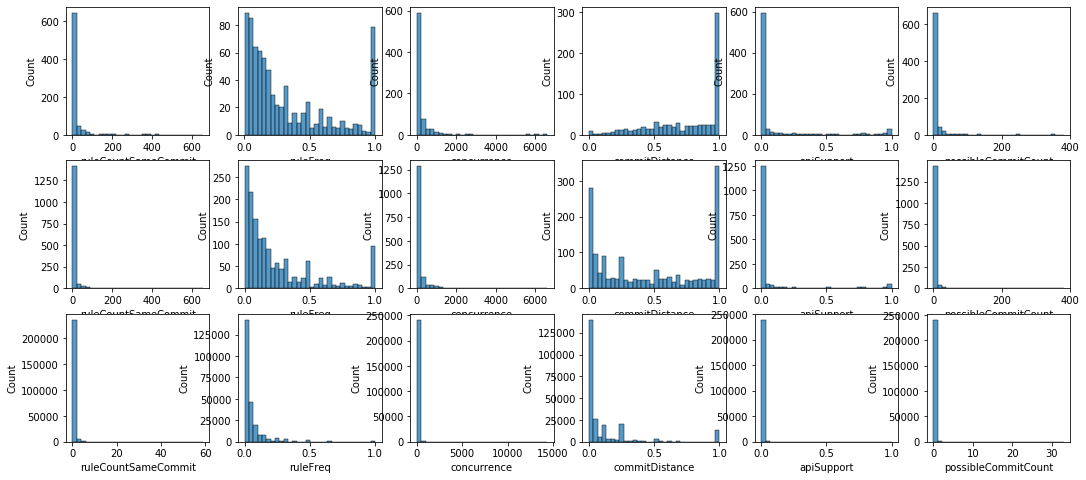

In [4]:
data = [rules[rules["isConfirmed"]], rules[rules["isPossible"]], rules[(~rules["isPossible"]) & (~rules["isConfirmed"])]]
axis = [
    "ruleCountSameCommit", "ruleFreq", "concurrence", "commitDistance", "apiSupport", "possibleCommitCount", 
    # "similarity"
]
fig, axes = plt.subplots(3, len(axis), figsize=(3 * len(axis), 8))
for i in range(0, 3):
    for j in range(0, len(axis)):
        sns.histplot(data=data[i], x=axis[j], ax=axes[i][j], bins=30)
fig.show()

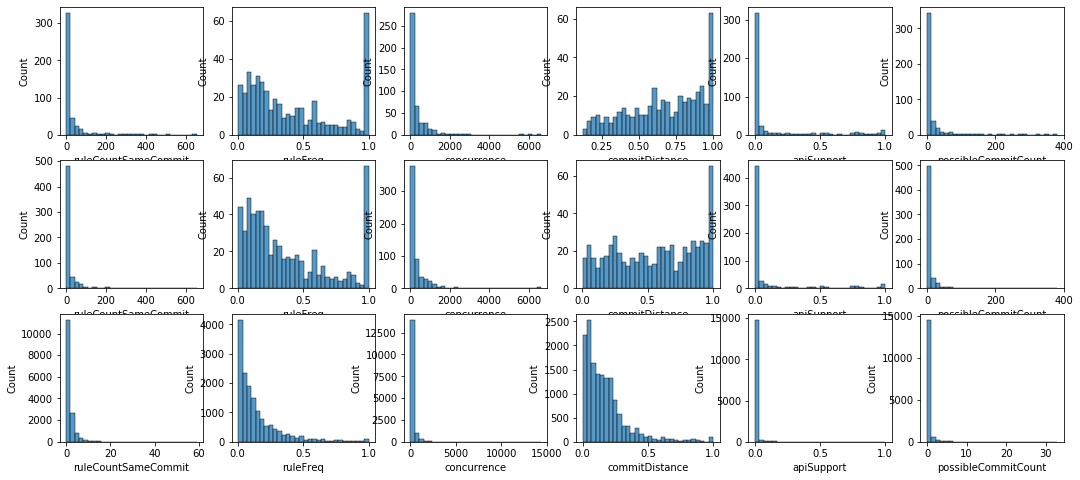

In [5]:
filtered_rules = rules[(rules["ruleCount"] >= 5) & (rules["concurrence"] >= 10)]
filtered_possible_rules = filtered_rules[filtered_rules["isPossible"]]
filtered_confirmed_rules = filtered_rules[filtered_rules["isConfirmed"]]
data = [
    filtered_rules[filtered_rules["isConfirmed"]], 
    filtered_rules[filtered_rules["isPossible"]], 
    filtered_rules[(~filtered_rules["isPossible"]) & (~filtered_rules["isConfirmed"])]
]
fig, axes = plt.subplots(3, len(axis), figsize=(3 * len(axis), 8))
for i in range(0, 3):
    for j in range(0, len(axis)):
        sns.histplot(data=data[i], x=axis[j], ax=axes[i][j], bins=30)
fig.show()

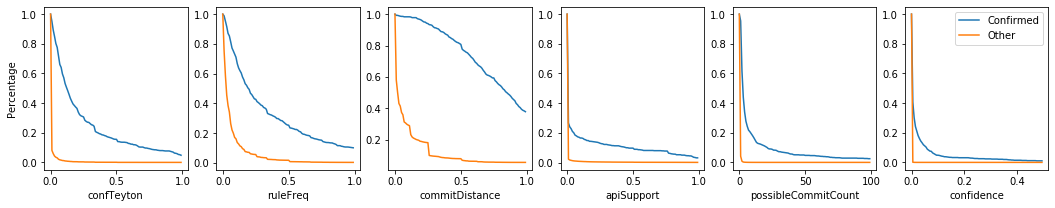

In [6]:
def get_dist(rules, possible_rules, confirmed_rules, metric, min_val, max_val, interval):
    possible_vals = []
    confirmed_vals = []
    other_vals = []
    for i in np.arange(min_val, max_val, interval):
        possible_vals.append(len(possible_rules[possible_rules[metric] >= i]) / len(possible_rules))
        confirmed_vals.append(len(confirmed_rules[confirmed_rules[metric] >= i]) / len(confirmed_rules))
        other_vals.append(len(other_rules[other_rules[metric] >= i]) / len(other_rules))
    return possible_vals, confirmed_vals, other_vals
params = [
    # ("ruleCountSameCommit", 0, 600, 6),
    # ("ruleFreqSameCommit", 0, 1, 0.01),
    # ("ruleFreqToLibSameCommit", 0, 1, 0.01),
    # ("ruleCount", 0, 600, 6), 
    ("confTeyton", 0, 1, 0.01),
    ("ruleFreq", 0, 1, 0.01), 
    # ("concurrence", 0, 1000, 10), 
    # ("popularityRegularization", 0, 1, 0.01),
    # ("positionSupport", 0, 1, 0.01), 
    ("commitDistance", 0, 1, 0.01),
    # ("methodChangeCount", 0, 100, 1),
    ("apiSupport", 0, 1, 0.01),
    ("possibleCommitCount", 0, 100, 1),
    # ("similarity", 0, 1, 0.01),
    ("confidence", 0, 0.5, 0.005),
    
]
fig, axes = plt.subplots(1, len(params), figsize=(3 * len(params), 3))
for i, param in enumerate(params):
    possible, confirmed, other = get_dist(rules, possible_rules, confirmed_rules, *param)
    x = list(np.arange(param[1], param[2], param[3]))
    axes[i].plot(x, confirmed, label="Confirmed")
    # axes[i].plot(x, possible, label="Possible")
    axes[i].plot(x, other, label="Other")
    axes[i].set_xlabel(param[0])
    if i == 0:
        axes[i].set_ylabel("Percentage")
    if i == len(params) - 1:
        axes[i].legend()
fig.show()
fig.savefig("pic/dist.pdf", bbox_inches="tight")

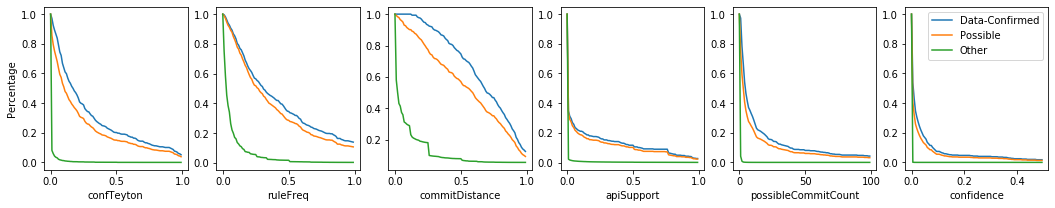

In [7]:
fig, axes = plt.subplots(1, len(params), figsize=(3 * len(params), 3))
for i, param in enumerate(params):
    possible, confirmed, other = get_dist(filtered_rules, filtered_possible_rules, filtered_confirmed_rules, *param)
    x = list(np.arange(param[1], param[2], param[3]))
    axes[i].plot(x, confirmed, label="Data-Confirmed")
    axes[i].plot(x, possible, label="Possible")
    axes[i].plot(x, other, label="Other")
    axes[i].set_xlabel(param[0])
    if i == 0:
        axes[i].set_ylabel("Percentage")
    if i == len(params) - 1:
        axes[i].legend()
fig.show()

In [8]:
def show_dist2(filter_func):
    print("# possible = {}({:.2%}), # confirmed = {}({:.2%}), # other = {}({:.2%})".format(
            len(filter_func(possible_rules)),
            len(filter_func(possible_rules)) / len(possible_rules),
            len(filter_func(confirmed_rules)),
            len(filter_func(confirmed_rules)) / len(confirmed_rules),
            len(filter_func(other_rules)),
            len(filter_func(other_rules)) / len(other_rules),
    ))
show_dist2(lambda rules: rules[(rules["ruleCount"] >= 5) & (rules["concurrence"] >= 10)])
show_dist2(lambda rules: rules[(rules["ruleCount"] >= 2) & (rules["concurrence"] >= 15) & (rules["positionSupport"] >= 0.4)])

# possible = 598(39.08%), # confirmed = 446(58.45%), # other = 15439(6.38%)
# possible = 728(47.58%), # confirmed = 482(63.17%), # other = 20089(8.30%)


In [9]:
def show_dist(metric, min_val, max_val, interval):
    possible_rules = rules[rules["isPossible"]]
    confirmed_rules = rules[rules["isConfirmed"]]
    other_rules = rules[~rules["isConfirmed"] & ~rules["isPossible"]]
    print("Distribution of {}:".format(metric))
    for i in np.arange(min_val, max_val, interval):
        print("{} >= {:.2f}: # possible = {}({:.2%}), # confirmed = {}({:.2%}), # other = {}({:.2%})".format(
            metric, i,
            len(possible_rules[possible_rules[metric] >= i]),
            len(possible_rules[possible_rules[metric] >= i]) / len(possible_rules),
            len(confirmed_rules[confirmed_rules[metric] >= i]),
            len(confirmed_rules[confirmed_rules[metric] >= i]) / len(confirmed_rules),
            len(other_rules[other_rules[metric] >= i]),
            len(other_rules[other_rules[metric] >= i]) / len(other_rules),
        ))
    print("")
params = [
    ("ruleCountSameCommit", 0, 30, 1), 
    ("ruleFreqSameCommit", 0, 1, 0.02), 
    ("ruleCount", 0, 30, 1), 
    ("ruleFreq", 0, 1, 0.02), 
    ("concurrence", 0, 30, 1), 
    ("concurrenceAdjustment", 0, 1, 0.02),
    ("positionSupport", 0, 1, 0.02), 
    ("apiSupport", 0, 1, 0.02),
    ("possibleCommitCount", 0, 30, 1)
]
for param in params:
    show_dist(*param)

Distribution of ruleCountSameCommit:
ruleCountSameCommit >= 0.00: # possible = 1530(100.00%), # confirmed = 763(100.00%), # other = 242051(100.00%)
ruleCountSameCommit >= 1.00: # possible = 948(61.96%), # confirmed = 746(97.77%), # other = 29032(11.99%)
ruleCountSameCommit >= 2.00: # possible = 671(43.86%), # confirmed = 591(77.46%), # other = 6926(2.86%)
ruleCountSameCommit >= 3.00: # possible = 522(34.12%), # confirmed = 483(63.30%), # other = 2830(1.17%)
ruleCountSameCommit >= 4.00: # possible = 433(28.30%), # confirmed = 404(52.95%), # other = 1610(0.67%)
ruleCountSameCommit >= 5.00: # possible = 355(23.20%), # confirmed = 341(44.69%), # other = 1053(0.44%)
ruleCountSameCommit >= 6.00: # possible = 321(20.98%), # confirmed = 310(40.63%), # other = 727(0.30%)
ruleCountSameCommit >= 7.00: # possible = 291(19.02%), # confirmed = 285(37.35%), # other = 524(0.22%)
ruleCountSameCommit >= 8.00: # possible = 270(17.65%), # confirmed = 267(34.99%), # other = 410(0.17%)
ruleCountSameCommit >